<a href="https://colab.research.google.com/github/zeppelin-slash/Python-Explorations/blob/main/HW_1_telco_churn_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [ ]:
telco_df =  pd.read_csv('https://raw.githubusercontent.com/cjflanagan/cs68/master/Telco-Customer-Churn.csv')
telco_df = telco_df.drop(['customerID'],axis = 1)
telco_df.dropna(inplace=True)
telco_df = telco_df.drop(['TotalCharges'],axis = 1)
telco_df = telco_df.drop(['MonthlyCharges'],axis = 1)
telco_df['isAutoPay'] = np.where(telco_df['PaymentMethod'].str.contains('automatic'), 1, 0)

In [ ]:
numerical_cols = telco_df.columns[telco_df.dtypes=='int64'].tolist()
numerical_cols

['SeniorCitizen', 'tenure', 'isAutoPay']

In [ ]:
categorical_cols = telco_df.columns[telco_df.dtypes=='object'].tolist()
categorical_cols

['gender',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'Churn']

In [ ]:
binary_colmmns = telco_df[categorical_cols].nunique()[telco_df[categorical_cols].nunique() == 2].index.tolist()
binary_colmmns


['gender',
 'Partner',
 'Dependents',
 'PhoneService',
 'PaperlessBilling',
 'Churn']

In [ ]:
multi_valued_colmmns = telco_df[categorical_cols].nunique()[telco_df[categorical_cols].nunique() > 2].index.tolist()
multi_valued_colmmns

['MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaymentMethod']

In [ ]:
single_valued_colmmns = telco_df[categorical_cols].nunique()[telco_df[categorical_cols].nunique() == 1].index.tolist()
single_valued_colmmns
telco_df.drop(columns=single_valued_colmmns, inplace=True)

In [ ]:
# Transform binary_columns
for column in binary_colmmns :
  telco_df[column] = LabelEncoder().fit_transform(telco_df[column])

In [ ]:
 # Transform multivalued columns

dummies_adjusted_data = pd.get_dummies(data = telco_df, columns=multi_valued_colmmns, drop_first=True)
dummies_adjusted_data

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,Churn,isAutoPay,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,0,1,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
1,1,0,0,0,34,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1
2,1,0,0,0,2,1,1,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
3,1,0,0,0,45,0,0,0,1,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0
4,0,0,0,0,2,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5065,1,1,0,0,33,1,1,0,1,0,1,0,1,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,0,0
5066,1,0,1,0,44,0,0,0,1,1,0,0,0,0,0,0,1,0,1,0,0,0,1,0,1,0,1,0,0,0
5067,0,0,1,1,30,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
5068,0,0,1,0,71,1,1,0,1,0,0,0,1,1,0,1,0,1,0,1,0,1,0,1,0,0,1,0,0,0


In [ ]:
# Z-Score normalization

numerical_columns = dummies_adjusted_data[numerical_cols]
scaled_numerical = numerical_columns.div(numerical_columns.mean(), axis=1)
scaled_numerical.describe()
#Scaling Numerical columns
std = StandardScaler()
scaled = std.fit_transform(dummies_adjusted_data[numerical_cols])
scaled = pd.DataFrame(scaled,columns=numerical_cols)
scaled



,SeniorCitizen,tenure,isAutoPay
0,-0.436372,-1.268661,-0.884704
1,-0.436372,0.071895,-0.884704
2,-0.436372,-1.228038,-0.884704
3,-0.436372,0.518747,1.130322
4,-0.436372,-1.228038,-0.884704
...,...,...,...
5065,2.291624,0.031272,1.130322
5066,-0.436372,0.478124,1.130322
5067,-0.436372,-0.090596,1.130322
5068,-0.436372,1.574943,1.130322


In [ ]:
#dropping original values merging scaled values for numerical columns
dummies_adjusted_data = dummies_adjusted_data.copy()
data = dummies_adjusted_data.drop(columns = numerical_cols,axis = 1)
data = data.merge(scaled_numerical,left_index=True,right_index=True,how = "left")
data

,gender,Partner,Dependents,PhoneService,PaperlessBilling,Churn,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,SeniorCitizen,tenure,isAutoPay
0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0.000000,0.031027,0.000000
1,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0.000000,1.054912,0.000000
2,1,0,0,1,1,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0.000000,0.062054,0.000000
3,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0.000000,1.396207,2.277628
4,0,0,0,1,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.000000,0.062054,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5065,1,0,0,1,1,0,0,1,0,1,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,0,0,6.251541,1.023885,2.277628
5066,1,1,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,1,0,1,0,1,0,0,0,0.000000,1.365180,2.277628
5067,0,1,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0.000000,0.930805,2.277628
5068,0,1,0,1,1,0,0,0,0,1,1,0,1,0,1,0,1,0,1,0,1,0,0,1,0,0,0,0.000000,2.202904,2.277628


In [ ]:
telco_df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,TotalCharges,Churn,isAutoPay
0,0,0,1,0,1,0,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,1,Electronic check,29.85,0,0
1,1,0,0,0,34,1,No,DSL,Yes,No,Yes,No,No,No,One year,0,Mailed check,1889.5,0,0
2,1,0,0,0,2,1,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,1,Mailed check,108.15,1,0
3,1,0,0,0,45,0,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,0,Bank transfer (automatic),1840.75,0,1
4,0,0,0,0,2,1,No,Fiber optic,No,No,No,No,No,No,Month-to-month,1,Electronic check,151.65,1,0


In [ ]:
telco_df.shape

(5070, 20)

In [ ]:
telco_df.Churn.value_counts()

0    3738
1    1332
Name: Churn, dtype: int64

Check Data for missing values and edge cases

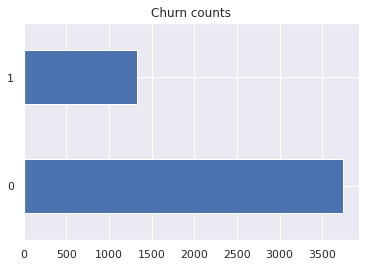

In [ ]:
telco_df.Churn.value_counts().plot(kind='barh', title='Churn counts')
plt.show() 

In [ ]:
sns.displot(telco_df['TotalCharges'])

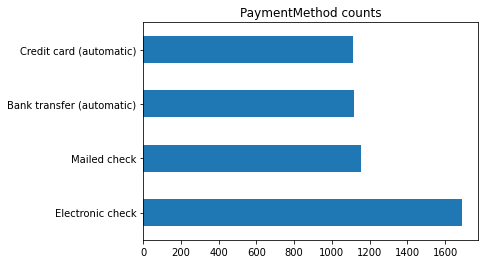

In [ ]:
telco_df.describe()
telco_df.MultipleLines.value_counts()
telco_df.gender.value_counts()
telco_df.InternetService.value_counts()

telco_df.PaymentMethod.value_counts().plot(kind='barh', title =  'PaymentMethod counts')
plt.show()
#rplot
#sns.set()
#cols = ['MultipleLines', 'gender', 'InternetService', 'Contract', 'PaymentMethod']


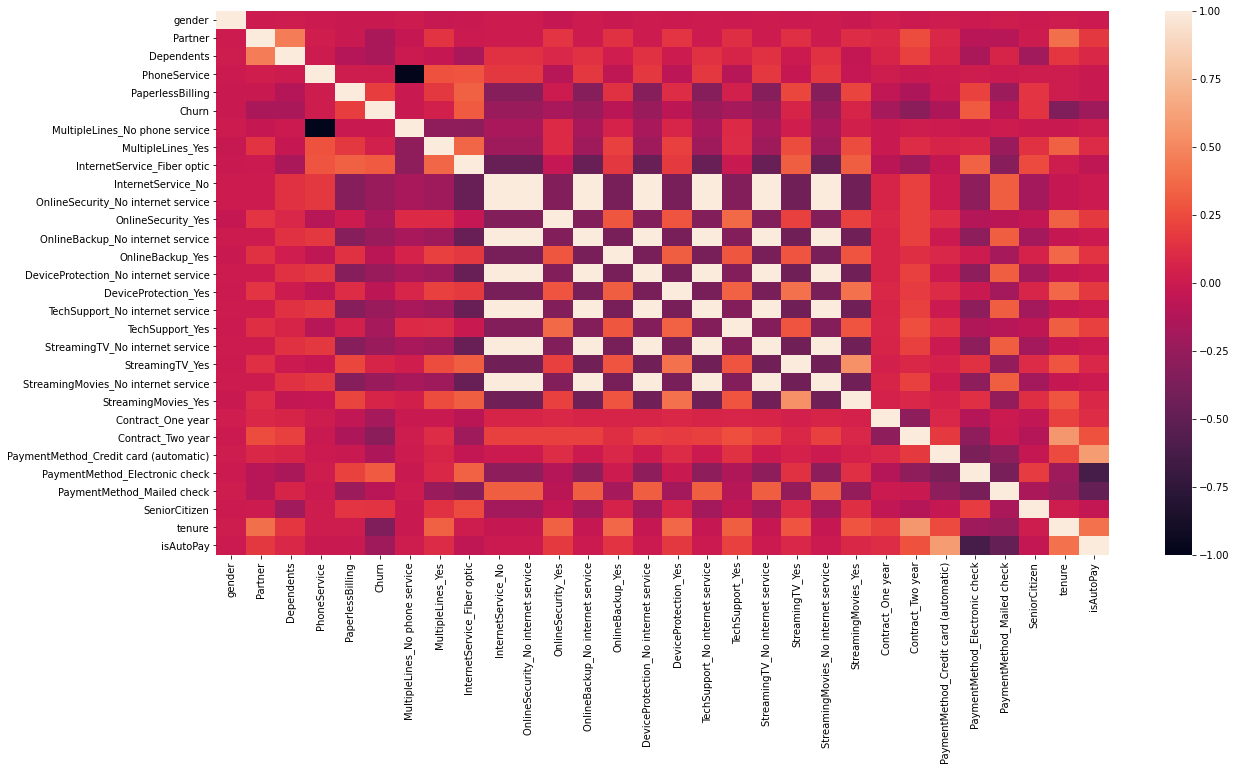

In [ ]:
corr_matrix = data.corr()

plt.figure(figsize=(20, 10))
sns.heatmap(corr_matrix)
plt.show()

In [ ]:
y = data.pop('Churn') # Removing Churn field and storing it in variable y
X = data

# Splitting data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

In [ ]:
X_train.head()

,gender,Partner,Dependents,PhoneService,PaperlessBilling,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,SeniorCitizen,tenure,isAutoPay
2100,1,1,0,1,0,0,1,1,0,0,0,0,0,0,1,0,0,0,1,0,1,1,0,0,0,0,0.000000,2.140851,2.277628
4900,1,1,0,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,6.251541,1.147992,0.000000
983,1,0,0,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0.000000,0.031027,0.000000
2720,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.000000,0.465402,0.000000
1888,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0.000000,0.713617,2.277628


# Fitting model

In [ ]:
# fit a model
clf = LogisticRegression(penalty='l2').fit(X_train, y_train)
# predict probabilities
predictions = clf.predict_proba(X_test)[:, 1]

# Evaluating model

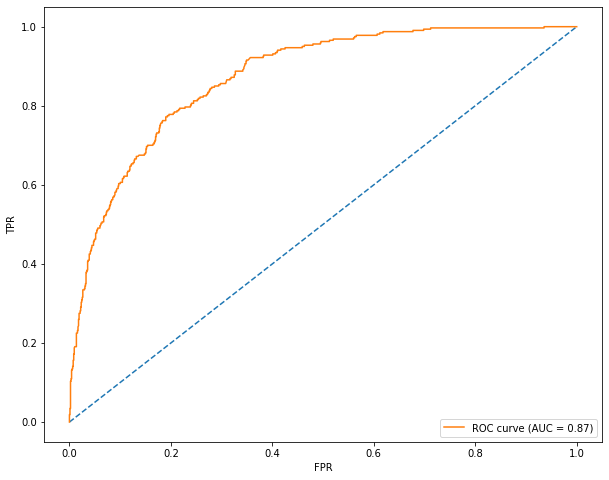

In [ ]:
# calculate scores
auc = roc_auc_score(y_test, predictions)

# calculate roc curves
fpr, tpr, _ = roc_curve(y_test, predictions)

plt.figure(figsize=(10, 8))
# plot horizontal line 
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % auc)
# axis labels
plt.xlabel('FPR')
plt.ylabel('TPR')
# show the legend
plt.legend(loc='lower right')
# show the plot
plt.show()

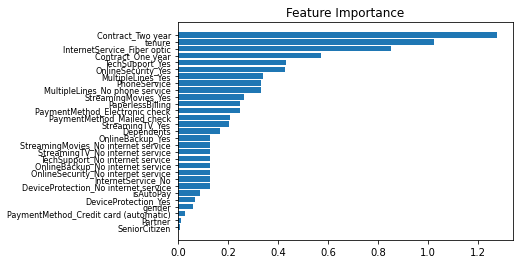

In [ ]:
feature_importance = abs(clf.coef_[0])
# feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

featfig = plt.figure()
featax = featfig.add_subplot(1, 1, 1)
featax.barh(pos, feature_importance[sorted_idx], align='center')
featax.set_yticks(pos)
featax.set_yticklabels(np.array(X.columns)[sorted_idx], fontsize=8)

plt.title('Feature Importance')
plt.show()